Duke Data: Extract RNA data for 21 patients

In [1]:
# import libraries
# import os
import numpy as np
import copy
from datetime import datetime
import pickle
import matplotlib.pyplot as plt

In [2]:
# read files
file1 = 'dataExportForRelease\\sqlViews\\vw_mRNASeqTotalCountsFtDetrick_release.txt'
file2 = 'dataExportForRelease\\sqlViews\\vw_mRNASeqKeyFtDetrick_release.txt'

Read from "RNA count" file

In [4]:
f1 = open(file1,'r')
f1.seek(3,0)             # set the file pointer, jump over utf-8 BOM
# f1.tell()
column_name = f1.readline()
f1firstrow = f1.tell()

In [5]:
f1size = f1.seek(0,2)    # total length of the file

In [6]:
RNA_names = ['RSAD2','IFI44L','LAMP3','SERPING1','IFI44','IFIT1','ISG15','SIGLEC1','OAS3','HERC5',
            'IFIT3','IFI6','OASL','IFI27','ATF3','MX1','OAS1','XAF1','IFIT2','OAS2',
            'LY6E','DDX58','TNFAIP6','RTP4']
# RNA_names_maxlen = 4
# for i in range(len(RNA_names)):
#     if RNA_names_maxlen < len(RNA_names[i]):
#         RNA_names_maxlen = len(RNA_names[i])    

Normalization of the RNA counts

In [7]:
f1.seek(f1firstrow,0)
RNAcounts_pre = f1.readlines()
RNAnamesall = []
# converting string to numbers
for i in range(len(RNAcounts_pre)):
    RNAcounts_pre[i] = RNAcounts_pre[i].split('\t')
    RNAnamesall.append(RNAcounts_pre[i][0])
    RNAcounts_pre[i] = [float(x) for x in RNAcounts_pre[i][1:]]

# len(RNAnamesall)

In [8]:
len(RNAcounts_pre)

26490

In [1139]:
RNAcounts_pre = np.array(RNAcounts_pre)
nc = RNAcounts_pre.shape[1]

In [1140]:
# 75% quantile normalizing
RNAcounts_pre_quantile = np.percentile(RNAcounts_pre,75,axis=0,interpolation='linear')
RNAcounts_pre_quantile[np.where(RNAcounts_pre_quantile==0)] = 1
RNAcounts_pre = np.transpose(np.array([RNAcounts_pre[:,x]/RNAcounts_pre_quantile[x] for x in range(nc)]))
RNAcounts_pre = RNAcounts_pre * np.mean(RNAcounts_pre_quantile)

In [1141]:
#  log transformation
RNAcounts_pre = np.log2(RNAcounts_pre + 0.5)

In [1142]:
# take out the import RNAs from the lise 'RNA_names'
impRNAind = [RNAnamesall.index(x) for x in RNA_names]
RNAcounts = RNAcounts_pre[impRNAind,:]

The following blocks do not do normalizing

In [1143]:
# # take out the 20 important RNA data
# RNAcounts = []
# f1.seek(f1firstrow,0)
# while f1.tell() != f1size:
#     current_line = f1.readline()
#     for i in range(len(RNA_names)):
#         current_line_namelen = current_line.find('\t',0)
#         if RNA_names[i] == current_line[:current_line_namelen]:
#             RNAcounts.append(current_line)
#             break
    
#     if len(RNAcounts) > len(RNA_names):
#         break          
        

In [1144]:
f1.close()

In [1145]:
# # converting string to numbers
# for i in range(len(RNAcounts)):
#     RNAcounts[i] = [float(x) for x in RNAcounts[i].split('\t')[1:]]
    
# RNAcounts = np.array(RNAcounts)
    
# # [len(RNAcounts[x]) for x in range(len(RNAcounts))]


Index with the "RNA key" file

In [1146]:
column_name = column_name.split('\t')
del column_name[0]
column_name[-1] = column_name[-1][:-1]

In [1147]:
f2 = open(file2,'r')
f2.seek(3,0)
table_head = f2.readline()
table_head.split('\t')
pot = f2.tell()

In [1148]:
subject_ids = ['HRV15-002','HRV15-003','HRV15-004','HRV15-005','HRV15-006','HRV15-007','HRV15-008',
               'HRV15-009','HRV15-011','HRV15-012','HRV15-013','HRV15-014','HRV15-015','HRV15-017',
               'HRV15-018','HRV15-019','HRV15-020','HRV15-021','HRV15-022','HRV15-023','HRV15-024']

In [1149]:
f2.seek(pot,0)
key = f2.readlines()
f2.close()

In [1150]:
for i in range(len(key)):
    key[i] = key[i].split('\t')

# subject id and sample id indexing
subject_sample_index = [[] for i in range(len(subject_ids))]
# subject id and key file line indexing
subject_key_lineind = copy.deepcopy(subject_sample_index)
# subject id and counts file column indexing
subject_counts_ind = copy.deepcopy(subject_sample_index)

In [1151]:
for i in range(len(key)):
    samid = key[i][0]
    subid = key[i][1]
    id = subject_ids.index(subid)
    subject_sample_index[id].append(samid)
    subject_key_lineind[id].append(i)
    

In [1152]:
for i in range(len(subject_counts_ind)):
    subject_counts_ind[i] = [column_name.index(x) for x in subject_sample_index[i]]
    

In [1153]:
# each element in the list contains an n * p array, 
# where n is the number of RNA's, and p is the number of datapoints for this subjcet
RNAcounts_by_subject = []
for i in range(len(subject_ids)):
    RNAcounts_by_subject.append(RNAcounts[:,subject_counts_ind[i]])

In [1154]:
RNAcounts_by_subject_info = [[] for i in range(len(subject_ids))]
for i in range(len(key)):
    subid = key[i][1]
    id = subject_ids.index(subid)
    for m in range(len(subject_key_lineind[id])):
        RNAcounts_by_subject_info[id].append(key[subject_key_lineind[id][m]]) 

Sort time for each subject

In [1155]:
dataorder_by_subject = []
for i in range(len(subject_ids)):
    cur_date = []
    for m in range(len(subject_key_lineind[i])):
        this_date = RNAcounts_by_subject_info[i][m][2] + ' ' + RNAcounts_by_subject_info[i][m][3]
        cur_date.append(datetime.strptime(this_date, '%Y-%m-%d %H:%M:%S'))
        
    dataorder_by_subject.append(np.argsort(cur_date))
          

In [1156]:
# sort all the RNA counts/information according to time
for i in range(len(subject_ids)):
    RNAcounts_by_subject[i] = RNAcounts_by_subject[i][:,dataorder_by_subject[i]]
    
for i in range(len(subject_ids)):
    RNAcounts_by_subject_info[i] = np.array(RNAcounts_by_subject_info[i])[dataorder_by_subject[i],:]
    
for i in range(len(subject_ids)):
    subject_sample_index[i] = np.array(subject_sample_index[i])[dataorder_by_subject[i]]
    
for i in range(len(subject_ids)):
    subject_key_lineind[i] = np.array(subject_key_lineind[i])[dataorder_by_subject[i]]
    
for i in range(len(subject_ids)):
    subject_counts_ind[i] = np.array(subject_counts_ind[i])[dataorder_by_subject[i]]

In [1157]:
# summary of RNA counts data

# RNAcounts_by_subject[i][m,]          i: subject     m: RNA
# RNAcounts_by_subject_info[i][m,]     i: subject     m: datapoint number
# subject_sample_index[i]              i: subject
# subject_key_lineind[i]               i: subject
# subject_counts_ind[i]                i: subject

In [1158]:
# save to pickle
pickle.dump((RNAcounts_by_subject,RNAcounts_by_subject_info,subject_sample_index,subject_key_lineind,subject_counts_ind),
            open('RNAcountdata.pickle', 'wb'))

More analysis

First, look at number of datapoints for each subject:

In [1159]:
numRNApoints = [len(RNAcounts_by_subject[x][1,]) for x in range(21)]

Then, look at some RNA count plots for each subject:

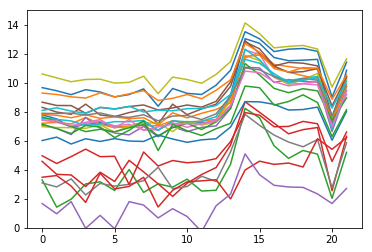

In [1160]:
subject_id = 8
numRNAnames = len(RNA_names)
for i in range(numRNAnames):
    plt.plot(range(numRNApoints[subject_id]),RNAcounts_by_subject[subject_id][i,])
    plt.ylim(0,15)
    
plt.show()

Furthermore, we found that:
1. HRV15-014 and HRV015-015 only have 2 datapoints (on the beginning days), so we remove them (the array indexes is 11 and 12);
2. For most of the subjects, the second last RNA count datapoint on "2015-10-08" or "2015-10-09" is "FollowUp", so we remove it;
3. For most of the subjects, the last RNA count datapoint on "2015-10-21" should be a typo; it should be "2015-09-21".

In [1161]:
del RNAcounts_by_subject[11:13]

In [1162]:
subject_ids_new = ['HRV15-002','HRV15-003','HRV15-004','HRV15-005','HRV15-006','HRV15-007','HRV15-008',
                   'HRV15-009','HRV15-011','HRV15-012','HRV15-013','HRV15-017','HRV15-018','HRV15-019',
                   'HRV15-020','HRV15-021','HRV15-022','HRV15-023','HRV15-024']

In [1163]:
for i in range(len(subject_ids_new)):
    RNAcounts_by_subject[i] = np.delete(RNAcounts_by_subject[i],-2,1)

Now, we want every subject to have 21 datapoints. Since we notice that the last 4 subjects have 19,19,19,9 datapoints, we do linear interpolation for them (the place of inerpolation is based on the corresponding time that we looked up in 'RNAcounts_by_subject_info').

In [1164]:
for i in range(-4,-1):
    temp = []
    for m in range(numRNAnames):
        temp.append(np.concatenate((RNAcounts_by_subject[i][m,:-2],
                        np.linspace(RNAcounts_by_subject[i][m,-2],RNAcounts_by_subject[i][m,-1],4)),axis=0))
        
    RNAcounts_by_subject[i] = np.array(copy.deepcopy(temp))
    

In [1165]:
temp = []
for m in range(numRNAnames):
    temp.append(np.concatenate((np.array([RNAcounts_by_subject[-1][m,0]]),
                 np.linspace(RNAcounts_by_subject[-1][m,1],RNAcounts_by_subject[-1][m,2],3),
                 np.array([RNAcounts_by_subject[-1][m,3]]),
                 np.linspace(RNAcounts_by_subject[-1][m,3],RNAcounts_by_subject[-1][m,4],4)[1:],
                 np.linspace(RNAcounts_by_subject[-1][m,4],RNAcounts_by_subject[-1][m,5],4)[1:],
                 np.linspace(RNAcounts_by_subject[-1][m,5],RNAcounts_by_subject[-1][m,6],4)[1:],
                 np.linspace(RNAcounts_by_subject[-1][m,6],RNAcounts_by_subject[-1][m,7],4)[1:],
                 np.linspace(RNAcounts_by_subject[-1][m,7],RNAcounts_by_subject[-1][m,8],5)[1:])))

RNAcounts_by_subject[-1] = np.array(copy.deepcopy(temp))

Now we generate a list of RNA counts, each element for a subject, which is a 1 * 21 np.array containing average over RNAs.

In [1176]:
RNAdata = []
for i in range(len(subject_ids_new)):
    RNAdata.append(RNAcounts_by_subject[i].mean(axis=0))

In [1179]:
# save data
pickle.dump(RNAdata, open('RNAdata_API.pickle', 'wb'))

The end of story.

In [1055]:
RNAcounts_by_subject_info[-1]

array([['DU15-01S10415 txt', 'HRV15-024', '2015-09-14', '08:45:00',
        'DayMinus3', 'AM', 'DayMinus3 AM', 'PaxGene RNA', 'DU15-01S01560',
        '2015-12-14', '101.7', '2.542', '1.263', '2.01', '1.11', '9.6',
        '80', '9.83', '7.8\n'],
       ['DU15-01S10412 txt', 'HRV15-024', '2015-09-14', '17:05:00',
        'DayMinus3', 'PM1', 'DayMinus3 PM1', 'PaxGene RNA',
        'DU15-01S00561', '2015-12-14', '97.78', '2.445', '1.152', '2.12',
        '1.76', '9.4', '81', '10.23', '7.5\n'],
       ['DU15-01S10413 txt', 'HRV15-024', '2015-09-15', '00:42:00',
        'DayMinus3', 'PM2', 'DayMinus3 PM2', 'PaxGene RNA',
        'DU15-01S03032', '2015-12-14', '75.16', '1.879', '0.891', '2.11',
        '0.29', '9.3', '57', '13.3', '5.8\n'],
       ['DU15-01S10414 txt', 'HRV15-024', '2015-09-15', '17:35:00',
        'DayMinus2', 'PM1', 'DayMinus2 PM1', 'PaxGene RNA',
        'DU15-01S01994', '2015-12-14', '65.94', '1.649', '0.801', '2.06',
        '0.39', '9.3', '54', '15.17', '5.1\n'],
    

In [974]:
np.linspace(RNAcounts_by_subject[i][m,-2],RNAcounts_by_subject[i][m,-1],4)

array([ 7.68817291,  8.41237122,  9.13656952,  9.86076783])

In [977]:
np.concatenate((RNAcounts_by_subject[i][m,:-2],
                        np.linspace(RNAcounts_by_subject[i][m,-2],RNAcounts_by_subject[i][m,-1],4)),axis=0)

IndexError: axis 1 out of bounds [0, 1)

In [574]:
subject_key_lineind[0]

array([300, 294, 295, 296, 291, 292, 293, 288, 289, 290, 297, 298, 299,
       301, 302, 303, 304, 305, 306, 307, 309, 308])

In [566]:
np.array(subject_key_lineind[0])[dataorder_by_subject[0]]

array([300, 294, 295, 296, 291, 292, 293, 288, 289, 290, 297, 298, 299,
       301, 302, 303, 304, 305, 306, 307, 309, 308])

In [552]:
(dataorder_by_subject[0])
len(subject_key_lineind[0])
np.array(RNAcounts_by_subject_info[1])[dataorder_by_subject[1],:]

array([['DU15-01S10024 txt', 'HRV15-003', '2015-09-14', '07:14:00',
        'DayMinus3', 'AM', 'DayMinus3 AM', 'PaxGene RNA', 'DU15-01S01540',
        '2015-12-07', '128.6', '3.214', '1.551', '2.07', '1.95', '9.3',
        '74.98225', '7.8', '9.9\n'],
       ['DU15-01S10031 txt', 'HRV15-003', '2015-09-14', '14:20:00',
        'DayMinus3', 'PM1', 'DayMinus3 PM1', 'PaxGene RNA',
        'DU15-01S00260', '2015-12-07', '81', '2.025', '0.951', '2.13',
        '1.99', '8.6', '44.38694', '12.3', '6.2\n'],
       ['DU15-01S10026 txt', 'HRV15-003', '2015-09-14', '22:25:07',
        'DayMinus3', 'PM2', 'DayMinus3 PM2', 'PaxGene RNA',
        'DU15-01S00591', '2015-12-07', '135.9', '3.399', '1.632', '2.08',
        '1.96', '9.2', '102.0958', '7.4', '10.5\n'],
       ['DU15-01S10027 txt', 'HRV15-003', '2015-09-15', '07:20:00',
        'DayMinus2', 'AM', 'DayMinus2 AM', 'PaxGene RNA', 'DU15-01S01742',
        '2015-12-07', '84.12', '2.103', '0.996', '2.11', '1.55', '9.3',
        '98.49518', '11.9'

In [517]:
dataorder_by_subject[0]

array([12,  6,  7,  8,  3,  4,  5,  0,  1,  2,  9, 10, 11, 13, 14, 15, 16,
       17, 18, 19, 21, 20], dtype=int64)

In [522]:
RNAcounts_by_subject[0][0]

array([ 270.,  494.,  615.,  511.,  321.,  382.,  341.,  292.,  376.,
        551.,  423.,   24.,  542.,  408.,  296.,  414.,  598.,  334.,
        464.,  170.,  584.,  526.])

In [528]:
RNAcounts_by_subject[0][0,(1,0,3)]

array([ 494.,  270.,  511.])

In [486]:
a = RNAcounts_by_subject_info[0][0][2]
b = RNAcounts_by_subject_info[0][0][3]
c = a + ' ' + b
d = datetime.strptime(c, '%Y-%m-%d %I:%M:%S')
c

'2015-09-16 07:53:00'

In [487]:
datetime.strptime('2015-09-16 07:53:01', '%Y-%m-%d %I:%M:%S')


datetime.datetime(2015, 9, 16, 7, 53, 1)

In [366]:
d = datetime.strptime(c, '%Y-%m-%d %I:%M:%S')
d = [d,(datetime.strptime('2015-06-16 07:53:00', '%Y-%m-%d %I:%M:%S'))]
d.sort()
d

[datetime.datetime(2015, 6, 16, 7, 53), datetime.datetime(2015, 9, 16, 7, 53)]

In [325]:
RNAcounts_by_subject[20][0,]

array([ 432.,  383.,  427.,  459.,  379.,  399.,  463.,  316.,  414.,  323.])

In [150]:
a = f2.readline().split('\t')[2:4]
a = a[0]+' '+a[1]
a
datetime_object = datetime.strptime(a, '%Y-%m-%d %I:%M:%S')

ValueError: time data '2015-09-19 23:19:00' does not match format '%Y-%m-%d %I:%M:%S'

In [167]:
datetime.strptime(b,'%Y-%m-%d %I:%M:%S')
a

'2015-09-19 23:19:00'

In [169]:
b = '2015-9-14 1:33:20'
b

'2015-9-14 1:33:20'

In [106]:
f2.readline().split('\t')

['DU15-01S10131 txt',
 'HRV15-007',
 '2015-09-18',
 '15:15:00',
 'Day1',
 'PM1',
 'Day1 PM1',
 'PaxGene RNA',
 'DU15-01S05107',
 '2015-12-14',
 '52.01',
 '1.3',
 '0.615',
 '2.11',
 '1.82',
 '9.3',
 '17.89957',
 '19.2',
 '4\n']

In [86]:
a = 'ACR';
a;

In [241]:
a.find('\t')

5

In [242]:
current_line.find('\t')

6

In [243]:
a

'ADAD2\t'

In [244]:
a[:3]

'ADA'